In [1]:
import os
import numpy as np
from scipy import integrate, linalg
from matplotlib import pyplot as py
%matplotlib inline

In [2]:
filepath = os.path.join('geminism.dat')
with open(filepath, 'r') as infile:
    x, y = np.loadtxt(infile, dtype=float, unpack=True)

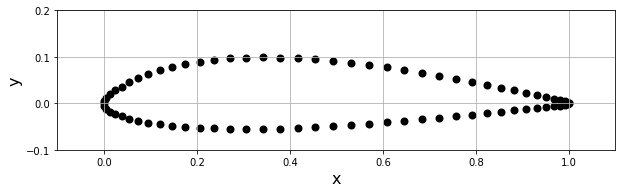

In [3]:
width = 10
py.figure(figsize=(width, width))
py.grid()
py.xlabel('x', fontsize=16)
py.ylabel('y', fontsize=16)
py.scatter(x, y, color='k', linewidth=2)
py.axis('scaled', adjustable='box')
py.xlim(-0.1, 1.1)
py.ylim(-0.1, 0.2);

In [4]:
class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2
        self.length = np.sqrt((xb - xa)**2 + (yb - ya)**2)
        
        if xb - xa <= 0.0:
            self.beta = np.arccos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = np.pi + np.arccos(-(yb - ya) / self.length)
            
        if self.beta <= np.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'
            
        self.sigma = 0.0
        self.vt = 0.0
        self.cp = 0.0

In [5]:
N = 78
panels = np.empty(N, dtype=object)
for i in range(N):
    panels[i] = Panel(x[i], y[i], x[i+1], y[i+1])

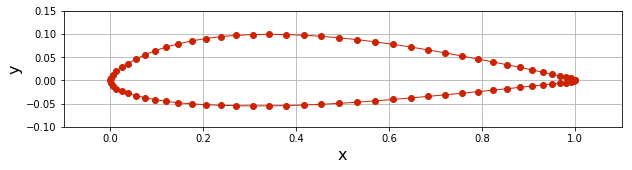

In [47]:
width = 10
py.figure(figsize=(width, width))
py.grid()
py.xlabel('x', fontsize=16)
py.ylabel('y', fontsize=16)
py.plot(np.append([panel.xa for panel in panels], panels[0].xa),
            np.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
py.axis('scaled', adjustable='box')
py.xlim(-0.1, 1.1)
py.ylim(-0.1, 0.15);

In [7]:
class Freestream:
    def __init__(self, u_inf=1.0, alpha=0.0):
        self.u_inf = u_inf
        self.alpha = np.radians(alpha)

def integral(x, y, panel, dxdk, dydk):
    def integrand(s):
        return (((x - (panel.xa - np.sin(panel.beta) * s)) * dxdk +
                 (y - (panel.ya + np.cos(panel.beta) * s)) * dydk) /
                ((x - (panel.xa - np.sin(panel.beta) * s))**2 + 
                 (y - (panel.ya + np.cos(panel.beta) * s))**2))
    return integrate.quad(integrand, 0.0, panel.length)[0]

def source_contribution_normal(panels):
    A = np.empty((panels.size, panels.size), dtype=float)
    np.fill_diagonal(A, 0.5)
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / np.pi * integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 np.cos(panel_i.beta),
                                                 np.sin(panel_i.beta))
    return A

def vortex_contribution_normal(panels):
    A = np.empty((panels.size, panels.size), dtype=float)
    np.fill_diagonal(A, 0.0)
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5 / np.pi * integral(panel_i.xc, panel_i.yc,
                                                  panel_j,
                                                  np.sin(panel_i.beta),
                                                  -np.cos(panel_i.beta))
    return A

def kutta_condition(A_source, B_vortex):
    b = np.empty(A_source.shape[0] + 1, dtype=float)
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    b[-1] = -np.sum(A_source[0,:] + A_source[-1,:])
    return b

def build_singularity_matrix(A_source, B_vortex):
    A = np.empty((A_source.shape[0] + 1, A_source.shape[1] + 1), dtype = float)
    A[:-1, :-1] = A_source
    A[:-1, -1] = np.sum(B_vortex, axis=1)
    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A

def build_freestream_rhs(panels, freestream):
    b = np.empty(panels.size + 1, dtype=float)
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
    b[-1] = -freestream.u_inf * (np.sin(freestream.alpha - panels[0].beta) +
                                 np.sin(freestream.alpha - panels[-1].beta))
    return b

def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    A = np.empty((panels.size, panels.size + 1), dtype=float)
    A[:, :-1] = B_vortex
    A[:, -1] = -np.sum(A_source, axis=1)
    b = freestream.u_inf * np.sin([freestream.alpha - panel.beta
                                   for panel in panels])
    strengths = np.append([panel.sigma for panel in panels], gamma)
    tangential_velocities = np.dot(A, strengths) + b
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]
        
def compute_pressure_coefficient(panels, freestream):
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2


In [8]:
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)
A = build_singularity_matrix(A_source, B_vortex)

In [9]:
N_alpha = 13
alpha = np.linspace(-8.0, 16.0, N_alpha)
p_inf = 101325.0 #Pascals
rho = 1.225 #kg/m^3
Re = 300000.0
chord = x.max() - x.min()
mu = 1.73 * 10**(-5) #Ns/m^2
u_inf = mu * Re / (rho * chord)

In [10]:
u_inf

4.236734693877551

In [11]:
def Lift(N, panels, freestream, p_inf, rho):
    p = np.empty(N, dtype=float)
    beta = np.empty(N, dtype=float)
    length =np.empty(N, dtype=float)
    for j in range(N):
        p[j] = p_inf + ((1/2) *  panels[j].cp * rho * freestream.u_inf**2)
        beta[j] = panels[j].beta
        length[j] = panels[j].length
    
    Lift = -np.sum(p * np.sin(beta)* length)
    return Lift

In [12]:
L = np.empty(N_alpha, dtype=float)
cp = np.empty((N, N_alpha), dtype=float)
for i in range(N_alpha):
    freestream = Freestream(u_inf, alpha[i])
    b = build_freestream_rhs(panels, freestream)
    strengths = np.linalg.solve(A, b)
    for k, panel in enumerate(panels):
        panel.sigma = strengths[k]
    gamma = strengths[-1]
    compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)
    compute_pressure_coefficient(panels, freestream)
    for n, panel in enumerate(panels):
        cp[n,i] = panel.cp
    L[i] = Lift(N, panels, freestream, p_inf, rho)

In [13]:
C_L = L / (0.5 * rho * u_inf**2 * chord)
C_L

array([-0.76824496, -0.5229158 , -0.2744135 , -0.02394874,  0.22725825,
        0.4779836 ,  0.72700581,  0.97311168,  1.21510218,  1.45179838,
        1.68204712,  1.90472663,  2.11875206])

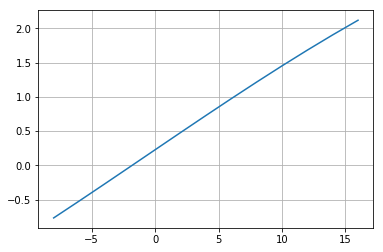

In [14]:
py.plot(alpha, C_L);
py.grid();

In [15]:
def get_velocity_field(panels, freestream, X, Y):
    """
    Computes the velocity field on a given 2D mesh.
    
    Parameters
    ---------
    panels: 1D array of Panel objects
        The source panels.
    freestream: Freestream object
        The freestream conditions.
    X: 2D Numpy array of floats
        x-coordinates of the mesh points.
    Y: 2D Numpy array of floats
        y-coordinate of the mesh points.
    
    Returns
    -------
    u: 2D Numpy array of floats
        x-component of the velocity vector field.
    v: 2D Numpy array of floats
        y-component of the velocity vector field.
    """
    # freestream contribution
    u = freestream.u_inf * np.cos(freestream.alpha) * np.ones_like(X, dtype=float)
    v = freestream.u_inf * np.sin(freestream.alpha) * np.ones_like(X, dtype=float)
    # add the contribution from each source (superposition powers!!!)
    vec_intregral = np.vectorize(integral)
    for panel in panels:
        u += panel.sigma / (2.0 * np.pi) * vec_intregral(X, Y, panel, 1.0, 0.0)
        v += panel.sigma / (2.0 * np.pi) * vec_intregral(X, Y, panel, 0.0, 1.0)
    
    return u, v

In [16]:
# define a mesh grid
nx, ny = 20, 20  # number of points in the x and y directions
x_start, x_end = -1.0, 2.0
y_start, y_end = -0.3, 0.3
X, Y = np.meshgrid(np.linspace(x_start, x_end, nx),
                      np.linspace(y_start, y_end, ny))

# compute the velocity field on the mesh grid
u, v = get_velocity_field(panels, freestream, X, Y)

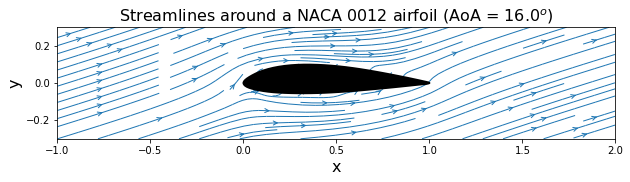

In [17]:
width = 10
py.figure(figsize=(width, width))
py.xlabel('x', fontsize=16)
py.ylabel('y', fontsize=16)
py.streamplot(X, Y, u, v,
                  density=1, linewidth=1, arrowsize=1, arrowstyle='->')
py.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
py.axis('scaled', adjustable='box')
py.xlim(x_start, x_end)
py.ylim(y_start, y_end)
py.title('Streamlines around a NACA 0012 airfoil (AoA = ${}^o$)'.format(alpha[i]),
             fontsize=16);

In [ ]:
#boundary layer stuff

In [67]:
def solve_panel_method(panels, An, Bn, freestream):
    # Assemble the system.
    A = build_singularity_matrix(An, Bn)
    b = build_freestream_rhs(panels, freestream)
    
    # Solve the system for the singularity strengths.
    strengths = np.linalg.solve(A, b)

    # Store the source-sheet strengths and the vortex-sheet strength.
    sigmas = strengths[:-1]
    gamma = strengths[-1]
    
    # Compute the tangential velocity component on the panels.
    bt = freestreamb.u_inf * np.sin([freestream.alpha - p.beta for p in panels])
    ut = bt + np.dot(Bn, sigmas) - np.sum(An, axis=1) * gamma
    
    # Compute the pressure coefficient on the panels.
    cp = 1 - (ut / freestreamb.u_inf)**2
    
    return ut, cp

In [76]:
panelsb = np.empty(N, dtype=object)
for i in range(N):
    panelsb[i] = Panel(x[i], y[i], x[i+1], y[i+1])
    
A_sourceb = source_contribution_normal(panelsb)
B_vortexb = vortex_contribution_normal(panelsb)
freestreamb = Freestream(u_inf, alpha=4.0)
ut1, cp1 = solve_panel_method(panelsb, A_sourceb, B_vortexb, freestreamb)

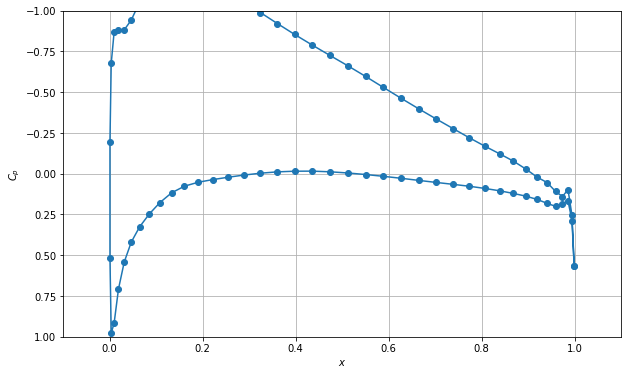

In [77]:
py.figure(figsize=(10.0, 6.0))
py.grid()
py.xlabel('$x$')
py.ylabel('$C_p$')
py.plot([p.xc for p in panelsb], cp1, marker='o')
py.xlim(-0.1, 1.1)
py.ylim(1.0, -1.0);

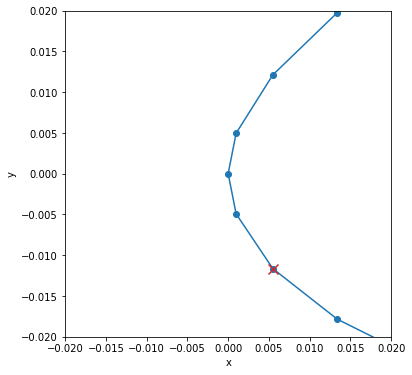

In [79]:
idx = np.where(ut1 >= 0.0)[0][0]
x_stagn, y_stagn = panelsb[idx].xa, panelsb[idx].ya

# Plot the panels.
py.figure(figsize=(6.0, 6.0))
py.xlabel('x')
py.ylabel('y')
py.plot([p.xa for p in panelsb] + [panelsb[-1].xb],
            [p.ya for p in panelsb] + [panelsb[-1].yb],
            marker='o')
py.scatter(x_stagn, y_stagn, c='C3', marker='x', s=100, zorder=10)
py.axis('scaled', adjustable='box')
py.xlim(-0.02, 0.02)
py.ylim(-0.02, 0.02);

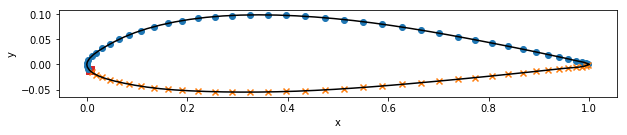

In [81]:
upper = panelsb[idx - 1::-1]
lower = panelsb[idx:]

# Plot the panels.
py.figure(figsize=(10.0, 6.0))
py.xlabel('x')
py.ylabel('y')
py.plot(x, y, color='black')
py.scatter(x_stagn, y_stagn, c='C3', marker='s', s=60)
py.scatter([p.xc for p in upper], [p.yc for p in upper],
               marker='o')
py.scatter([p.xc for p in lower], [p.yc for p in lower],
               marker='x')
py.axis('scaled', adjustable='box');

In [83]:
def running_coordinates(panels):
    ds = [0.0, 0.5 * panels[0].length]
    for i in range(len(panels) - 1):
        ds.append(0.5 * (panels[i].length + panels[i + 1].length))
    s = np.cumsum(ds)
    return s

s_upper = running_coordinates(upper)
s_lower = running_coordinates(lower)

In [84]:
# Grab the tangential velocities on both sides.

# Upper side.
Ue_upper = np.empty(len(upper) + 1)
Ue_upper[0] = 1e-6
Ue_upper[1:] = -ut1[idx - 1::-1]

# Lower side.
Ue_lower = np.empty(len(lower) + 1)
Ue_lower[0] = 1e-6
Ue_lower[1:] = ut1[idx:]